In [1]:
%matplotlib inline

In [2]:
from Bio import SeqIO, Phylo
import random
import numpy as np
import glob
from scipy import stats

import supporting_functions
import weighting_methods

In [7]:
from matplotlib import pyplot as plt
import matplotlib
matplotlib.rcParams['xtick.labelsize'] = 16
matplotlib.rcParams['ytick.labelsize'] = 16
matplotlib.rcParams['axes.labelsize'] = 18
matplotlib.rcParams['axes.titlesize'] = 18

matplotlib.rcParams['axes.grid'] = True
matplotlib.rcParams['grid.color'] = '0.5'
matplotlib.rcParams['grid.linewidth'] = '0.5'

matplotlib.rcParams['axes.edgecolor'] = '0.25'
matplotlib.rcParams['xtick.color'] = '0'
matplotlib.rcParams['ytick.color'] = '0'

matplotlib.rcParams['xtick.major.width'] = 1
matplotlib.rcParams['ytick.major.width'] = 1
matplotlib.rcParams['ytick.major.size'] = 5
matplotlib.rcParams['xtick.major.size'] = 5
matplotlib.rcParams['axes.spines.right'] = True
matplotlib.rcParams['axes.spines.left'] = True
matplotlib.rcParams['axes.spines.top'] = True
matplotlib.rcParams['axes.spines.bottom'] = True

matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = 'helvetica'
matplotlib.rcParams['font.weight']='normal'
matplotlib.rcParams['axes.axisbelow'] = True

In [25]:
import datetime
year = datetime.date.today().year
month = datetime.date.today().month
import os
figs_dir = '../Results/Figures/{}_{:02}'.format(year, month)
if not os.path.exists(figs_dir):
    os.makedirs(figs_dir)

# Write bootstrap sampled fasta files

In [ ]:
for fasta_file in glob.glob('../Data/psicov150_aln_pdb/aln_fasta_max1k/*.fasta'):
#     fasta_file = '../Data/psicov150_aln_pdb/aln_fasta_max1k/1aoeA.fasta'
    protein = fasta_file.split('/')[-1]
    records = list(SeqIO.parse(fasta_file, 'fasta'))
    length = len(records[0].seq)
    indices = range(length)
    selection = [random.choice(indices) for i in range(length)]
    with open('../Data/psicov150_aln_pdb/aln_fasta_max1k_bootstrap/{}'.format(protein), 'w') as outfile:
        for seq in records[:]:
            str_seq = str(seq.seq)
            new_seq = [str_seq[i] for i in selection]
            outfile.write('>{}\n'.format(seq.id))
            outfile.write('{}\n'.format(''.join(new_seq)))

# Run FastTree/IQtree pipeline offline

# Calculate weights on the new trees

In [64]:
fasta_directory = '../Data/psicov150_aln_pdb/aln_fasta_max1k_bootstrap/'
#Just storing the output in the same directory
tree_directory = fasta_directory
weight_output_dir = fasta_directory

for fasta_file in sorted(glob.glob(fasta_directory+'*.fasta'))[:]:
    prot_name = fasta_file.split('/')[-1].split('.')[0]
    #First read in sequence data
    records = list(SeqIO.parse(fasta_file, 'fasta'))
    #And the tree
    tree_loc = tree_directory+'{}.fasta.treefile'.format(prot_name)
    try:
        tree = Phylo.read(tree_loc, rooted=False, format='newick')
    except FileNotFoundError:
        continue
    #Root the tree with my mid-point algorithm
    tree = supporting_functions.MP_root(tree)

    
    #GSC weights
    weights_dict =  weighting_methods.calc_GSC_weights(tree)
    weights_dict_id = {}
    for i,j in weights_dict.items():
        weights_dict_id[i.name] = j
    
    #Mean scaled
    mean_GSC = np.mean(list(weights_dict_id.values()))
    keys, vals = zip(*list(weights_dict_id.items()))
    vals = np.array(vals)/mean_GSC
    new_dict = dict(zip(keys, vals))
    with open(weight_output_dir+'{}_GSC_{}.weights'.format(prot_name, 'meanScale'),'w') as outfile:
        for record in records:
            outfile.write('{}\n'.format(new_dict[record.id]))
    
    #And max scaled
    max_GSC = np.max(list(weights_dict_id.values()))
    keys, vals = zip(*list(weights_dict_id.items()))
    vals = np.array(vals)/max_GSC
    new_dict = dict(zip(keys, vals))
    with open(weight_output_dir+'{}_GSC_{}.weights'.format(prot_name, 'maxScale'),'w') as outfile:
        for record in records:
            outfile.write('{}\n'.format(new_dict[record.id]))
    
    #ACL weights
    try:
        tree = Phylo.read(tree_loc, rooted=False, format='newick')
    except FileNotFoundError:
        continue
    if tree.is_bifurcating() == False:
        continue
    tree = supporting_functions.MP_root(tree)
    weights_dict, new_tree =  weighting_methods.calc_ACL_weights(tree)
    weights_dict_id = {}
    for i,j in weights_dict.items():
        weights_dict_id[i.name] = j
        
    #Mean scaled
    mean_ACL = np.mean(list(weights_dict_id.values()))
    keys, vals = zip(*list(weights_dict_id.items()))
    vals = np.array(vals)/mean_ACL
    new_dict = dict(zip(keys, vals))
    with open(weight_output_dir+'{}_ACL_{}.weights'.format(prot_name, 'meanScale'),'w') as outfile:
        for record in records:
            outfile.write('{}\n'.format(new_dict[record.id]))
    
    #And max scaled
    max_ACL = np.max(list(weights_dict_id.values()))
    keys, vals = zip(*list(weights_dict_id.items()))
    vals = np.array(vals)/max_ACL
    new_dict = dict(zip(keys, vals))
    with open(weight_output_dir+'{}_ACL_{}.weights'.format(prot_name, 'maxScale'),'w') as outfile:
        for record in records:
            outfile.write('{}\n'.format(new_dict[record.id]))

Potential for multiple midpoints. Choosing the first that I encounter
Potential for multiple midpoints. Choosing the first that I encounter
Potential for multiple midpoints. Choosing the first that I encounter
Potential for multiple midpoints. Choosing the first that I encounter
Potential for multiple midpoints. Choosing the first that I encounter
Potential for multiple midpoints. Choosing the first that I encounter
Potential for multiple midpoints. Choosing the first that I encounter
Potential for multiple midpoints. Choosing the first that I encounter


# Compare weights

**First an individual example**

0.9025991855568625


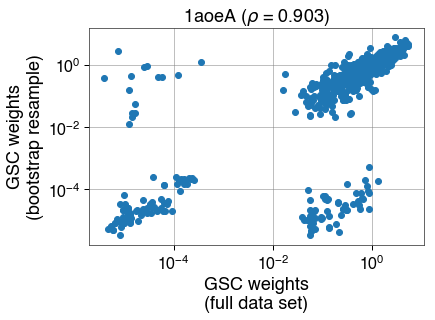

In [26]:
weights_a = '../Data/psicov150_aln_pdb/aln_fasta_max1k_bootstrap/1aoeA_GSC_meanScale.weights'
weights_b = '../Data/weights/1aoeA_GSC_meanScale.weights'

a = np.loadtxt(weights_a)
b = np.loadtxt(weights_b)
rval, trashc = stats.spearmanr(a, b)
print(rval)

fig, ax = plt.subplots()
ax.loglog(b,a, 'o')
ax.set_xlabel('GSC weights\n(full data set)')
ax.set_ylabel('GSC weights\n(bootstrap resample)')
ax.set_title(r'1aoeA ($\rho$ = {})'.format(round(rval, 3)))

plt.savefig('{}/1aoeA_GSC_boostrapweights.pdf'.format(figs_dir), bbox_inches='tight')

0.685307782038321


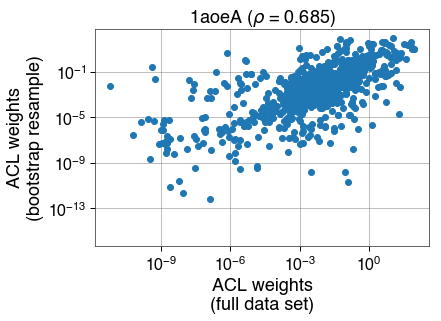

In [27]:
weights_a = '../Data/psicov150_aln_pdb/aln_fasta_max1k_bootstrap/1aoeA_ACL_meanScale.weights'
weights_b = '../Data/weights/1aoeA_ACL_meanScale.weights'

a = np.loadtxt(weights_a)
b = np.loadtxt(weights_b)
rval, trashc = stats.spearmanr(a, b)
print(rval)

fig, ax = plt.subplots()
ax.loglog(b,a, 'o')
ax.set_xlabel('ACL weights\n(full data set)')
ax.set_ylabel('ACL weights\n(bootstrap resample)')
ax.set_title(r'1aoeA ($\rho$ = {})'.format(round(rval, 3)))
plt.savefig('{}/1aoeA_ACL_boostrapweights.pdf'.format(figs_dir), bbox_inches='tight')

**And the whole set**

0.6367584989860439 0.6072467861902878


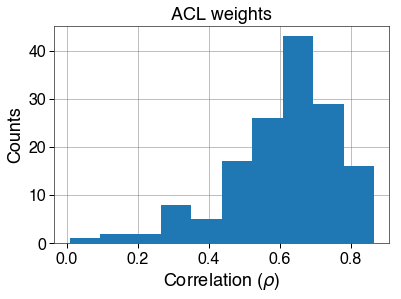

In [31]:
weights_a_generic = '../Data/psicov150_aln_pdb/aln_fasta_max1k_bootstrap/'
weights_b_generic = '../Data/weights/'

correlations = []
for weights_a in glob.glob(weights_a_generic+'*ACL_meanScale.weights'):
    file_name = weights_a.split('/')[-1]
    weights_b = weights_b_generic+file_name
    a = np.loadtxt(weights_a)
    b = np.loadtxt(weights_b)
    rval, trashc = stats.spearmanr(a, b)
    correlations.append(rval)
print(np.median(correlations), np.mean(correlations))

fig, ax = plt.subplots()
ax.hist(correlations)
ax.set_xlabel(r'Correlation ($\rho$)')
ax.set_ylabel('Counts')
ax.set_title('ACL weights')
plt.savefig('{}/ACL_boostrapweights.pdf'.format(figs_dir), bbox_inches='tight')

0.8549345886883863 0.8402464407591047


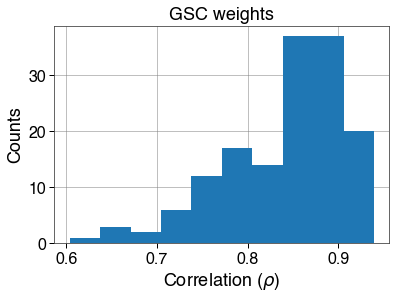

In [32]:
weights_a_generic = '../Data/psicov150_aln_pdb/aln_fasta_max1k_bootstrap/'
weights_b_generic = '../Data/weights/'

correlations = []
for weights_a in glob.glob(weights_a_generic+'*GSC_meanScale.weights'):
    file_name = weights_a.split('/')[-1]
    weights_b = weights_b_generic+file_name
    a = np.loadtxt(weights_a)
    b = np.loadtxt(weights_b)
    rval, trashc = stats.spearmanr(a, b)
    correlations.append(rval)
print(np.median(correlations), np.mean(correlations))

fig, ax = plt.subplots()
ax.hist(correlations)
ax.set_xlabel(r'Correlation ($\rho$)')
ax.set_ylabel('Counts')
ax.set_title('GSC weights')
plt.savefig('{}/GSC_boostrapweights.pdf'.format(figs_dir), bbox_inches='tight')

(0.18563196045958597, 0.23529780746032752)

In [55]:
fasta_directory = '../Data/psicov150_aln_pdb/aln_fasta_max1k_bootstrap/'
tree_directory = fasta_directory
weight_output_dir = fasta_directory

for fasta_file in sorted(glob.glob(fasta_directory+'*.fasta'))[:]:
    prot_name = fasta_file.split('/')[-1].split('.')[0]
#     print(prot_name)
    #First read in sequence data
    records = list(SeqIO.parse(fasta_file, 'fasta'))
    #And the tree
#     tree_loc = tree_directory+'{}.newick'.format(prot_name)
    tree_loc = tree_directory+'{}.fasta.treefile'.format(prot_name)


#     print(tree_loc)
    try:
        tree = Phylo.read(tree_loc, rooted=False, format='newick')
    except FileNotFoundError:
        continue
    if tree.is_bifurcating() == False:
        print('fuckkkkk')
        continue

In [56]:
tree.is_bifurcating()

True

In [48]:
tree.total_branch_length()

231.09114352099985

In [49]:
tree.root_with_outgroup('reference')
tree.total_branch_length()

231.09114352099957

In [50]:
tree.is_bifurcating()

False

In [51]:
tree = supporting_functions.MP_root(tree)

AssertionError: 